# Convergence Warning

In [1]:
from OOSfuncs import *
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import torch

wk = 8
window = 5
frequency = 1
cvs = 10

ind_vars = ['entropy', 'artcount', 'sCo', 'fCo',
       'sGom', 'fGom', 'sEnv', 'fEnv', 'sEpg', 'fEpg', 'sBbl', 'fBbl', 'sRpc',
       'fRpc', 'sEp', 'fEp', 'PCAsent', 'PCAall', 'PCAfreq']


for d_var in ['xomRet']:
    
    time_col = data_set(d_var)['date'] 
    time_lower = time_col[0]
    # time_lower= pd.Timestamp('2014-05-03')
    test_week_list = [time for time in time_col if time>=time_lower+pd.Timedelta(str(7*window*52)+'days')][::frequency]

    best_lambda_dic = {}
    
    for forecast_start in test_week_list[95:96]:

        data=data_set(d_var)

        ### 1. Get update and forecast window
        date_update_range, date_test_range, date_pca_range=get_test_row_range(data['date'], forecast_start, wk=wk, update_window=window)

        ### 2. Shift x to match the lag 
        lag_vars = ind_var_list(d_var, weeks=wk)
        # trend and WIPIyoy will not lag
        lag_vars.remove('trend')
        lag_vars.remove('WIPI_{}wk'.format(wk))
        data_x=data.copy()
        if wk == 8:
            data_x.loc[:,lag_vars]=data_x.loc[:,lag_vars].shift(8)

        else:
            data_x.loc[:,lag_vars]=data_x.loc[:,lag_vars].shift(4)

        ### 3. Prepare LHS data for training and testing
        data_ytrain= data[date_update_range]
        data_ytest = data[date_test_range]

        ### 4. Prepare RHS data for training and testing   
        # 4.1 Add PCA series
        data_x_pca = data_x[date_pca_range]
        data_x_pca = PCA_augment(data_x_pca)

        # 4.2 Select the train set (first few rows) and the test set (the last row)
        data_xtrain= data_x_pca.iloc[:np.sum(date_update_range),:]
        data_xtest = data_x_pca.iloc[[-1],:]   

        ### 5. Lasso Update and Prediction Process
        # 5.1 First, use grid search to choose the best Penalty 
        #     Then, run lasso using that panalty regression and update, 
        #     here, sm.add_constant adds a constant to RHS
        x_train = data_xtrain.loc[:,ind_vars]
        
        ## Choose the correct LHS var according to forecasting duration
        y_train = data_ytrain[f'{d_var}_t{wk}']


        train_xy = pd.concat([x_train,y_train],axis=1).dropna()
        y_train = train_xy.iloc[:,-1]
        x_train = train_xy.iloc[:,0:-1]
        # scaling is necessary in LASSO
        x_train = (x_train - x_train.mean())/x_train.std()
        

        ## Set up Lasso instance and grid search for penalty coefficient
        pre_model = Lasso(random_state=seed)
        param_grid = [{'alpha': np.exp(np.linspace(-3, 3, 40))}]
        
        print('Y Not Scaled:')
        grid_search = GridSearchCV(pre_model, param_grid, cv=cvs, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        print(grid_search.best_params_)
        
        print('Y Scaled:')
        y_train = (y_train - y_train.mean())/y_train.std()
        grid_search = GridSearchCV(pre_model, param_grid, cv=cvs, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        print(grid_search.best_params_)

Y Not Scaled:


/user/kh3191/.conda/envs/tmle/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+00, tolerance: 8.440e-01
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1988141887380742}
Y Scaled:
{'alpha': 0.04978706836786394}


# Hyperparameter: best lambda

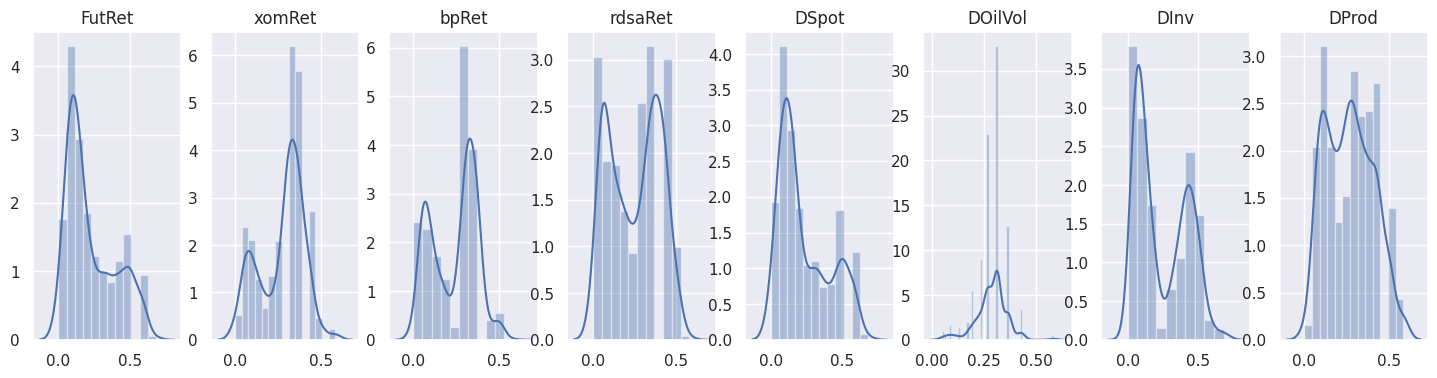

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

d_var_list = ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol', 'DInv', 'DProd']
fig, ax = plt.subplots(figsize=(18,4), ncols=8)
for i, d_var in enumerate(d_var_list):
    res = torch.load(f'best_lambda_{d_var}.pt')
    sns.distplot(list(res.values()), ax=ax[i])
    ax[i].set_title(d_var)
    ax[i].set_ylabel('')

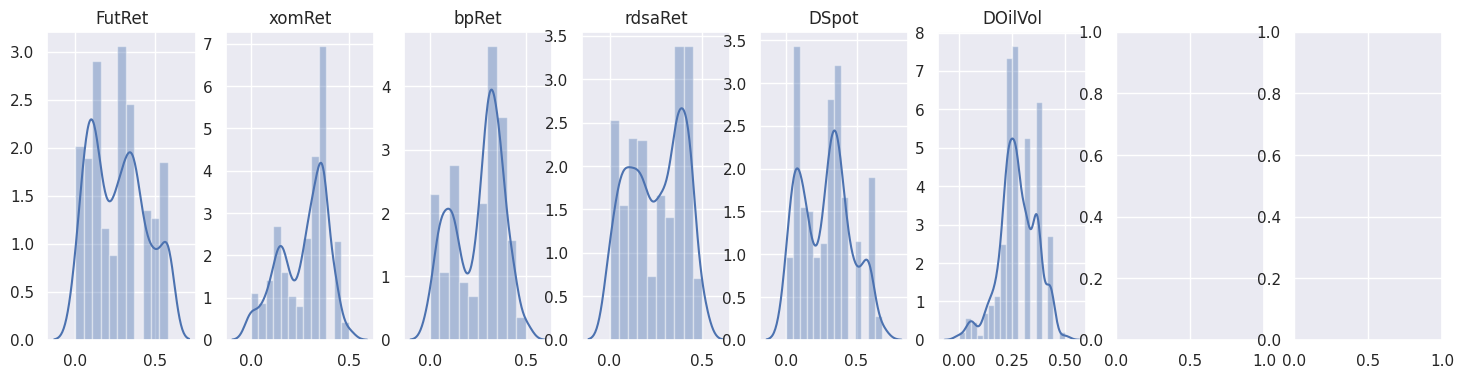

In [10]:
d_var_list = ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol']# 'DInv', 'DProd']
fig, ax = plt.subplots(figsize=(18,4), ncols=8)
for i, d_var in enumerate(d_var_list):
    res = torch.load(f'rolling_best_lambda_{d_var}.pt')
    sns.distplot(np.array(list(res.values()))[:,1], ax=ax[i])
    ax[i].set_title(d_var)
    ax[i].set_ylabel('')

# OOS R-squared

In [1]:
import pandas as pd
import numpy as np
seed = 12345
np.random.seed(seed)
import statsmodels.api as sm
import statsmodels.regression.linear_model as lm
from sklearn.linear_model import Lasso

from get_best_lambda import get_train_test_split
import torch

import re
from collections import Counter
from tqdm import tqdm

wk = 8
window = 5
frequency = 1
cvs = 10
rolling = True

df_cluster = pd.read_csv('TopicLabel_Cluster.csv').sort_values('X')
df_cluster.index = df_cluster['X'].apply(lambda x: x[:4]+x[5:7]+x[-2:])
df_cluster = df_cluster['cluster']
all_features = ['artcount', 'entropy'] + [f'meta_f{i+1}' for i in range(df_cluster.max())]\
                + [f'meta_s{i+1}' for i in range(df_cluster.max())]\
                + ['PCAsent', 'PCAall', 'PCAfreq']

def get_meta_label(lasso_features):

    lasso_features_cluster = []
    for lasso_feature in lasso_features:
        if re.match(r'f\d+$', lasso_feature):
            lasso_features_cluster.append('meta_f'+str(df_cluster[f"{YYYYMM_end}_{int(lasso_feature[1:])-1}"]))
        elif re.match(r's\d+$', lasso_feature):
            lasso_features_cluster.append('meta_s'+str(df_cluster[f"{YYYYMM_end}_{int(lasso_feature[1:])-1}"]))
        else:
            lasso_features_cluster.append(lasso_feature)
            
    return lasso_features_cluster

- replicate Panel B of last figure
- alpha grid should change from lasso to forward-lasso
- use old topic models

In [40]:
for d_var in d_var_list:
    trend = np.array(list(trend[d_var].values()))
    true = np.array(list(true[d_var].values()))
    pred = np.array(list(pred[d_var].values()))
    
    num = (true - pred).var()
    den = (true - trend).var()
    print(d_var, num/den)

FutRet 1.1802440888280428


# Replicated Figure 5

Dec 19

- inv and prod
- global topic model
- make codes more robust

Dec 21
- two variables on Tuesday
- [without normalization, with intercept] x [rolling] for [top_R2=2] (4 more variants)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from glob import glob

def get_R2(true_arr, pred_arr, trend_arr):
    num = (true_arr - pred_arr).var()
    den = (true_arr - trend_arr).var()
    return 1-num/den

def plot_blends(res, wt_max=1):
    R2 = {}
    for d_var in res.keys():#d_var_list:
        pred_arr = np.array(list(res[d_var]['pred'].values()))
        trend_arr = np.array(list(res[d_var]['trend'].values()))
        true_arr = np.array(list(res[d_var]['true'].values()))

        R2[d_var] = []
        wt_list = np.linspace(0,wt_max,20)
        for wt in wt_list:
            pred_w = wt*pred_arr + (1-wt)*trend_arr
            R2[d_var].append(get_R2(true_arr, pred_w, trend_arr))
            
    fig, ax = plt.subplots(figsize=(18,2), ncols=len(res.keys()))
    for i, d_var in enumerate(res.keys()):
        ax[i].plot(wt_list, R2[d_var])
        ax[i].set_title(d_var)
        ax[i].set_ylabel('R2')
        ax[i].set_xlabel('weight')

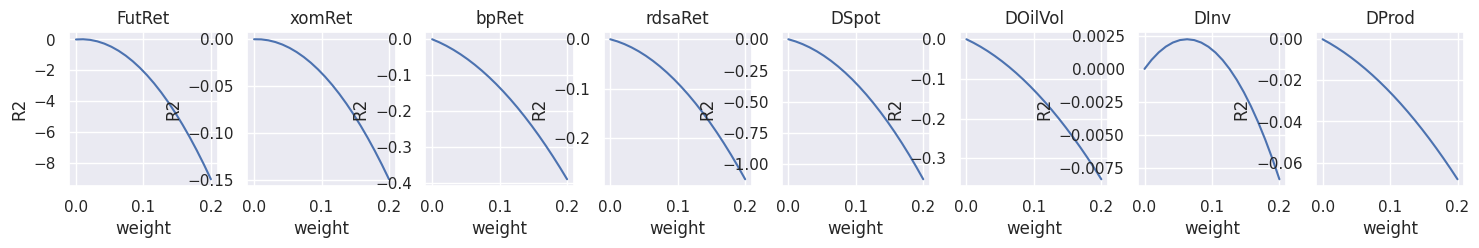

In [10]:
res_directory = glob('res_Forward_Lasso/*rolling:False*normalize:False*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

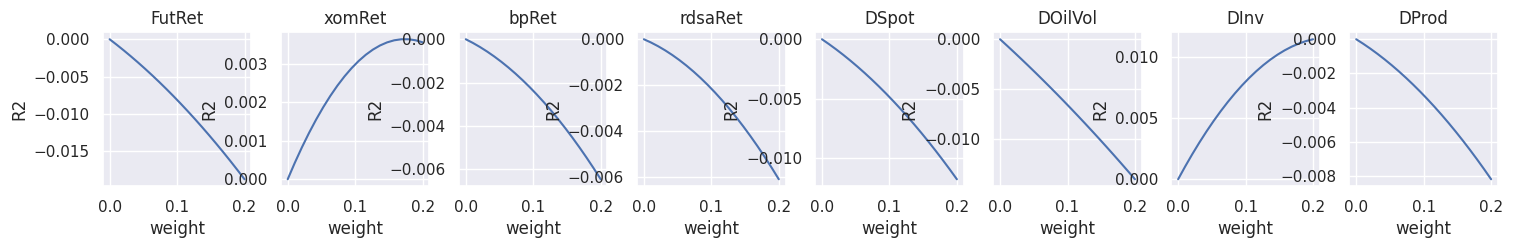

In [11]:
res_directory = glob('res_Forward_Lasso/*rolling:False*normalize:True*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

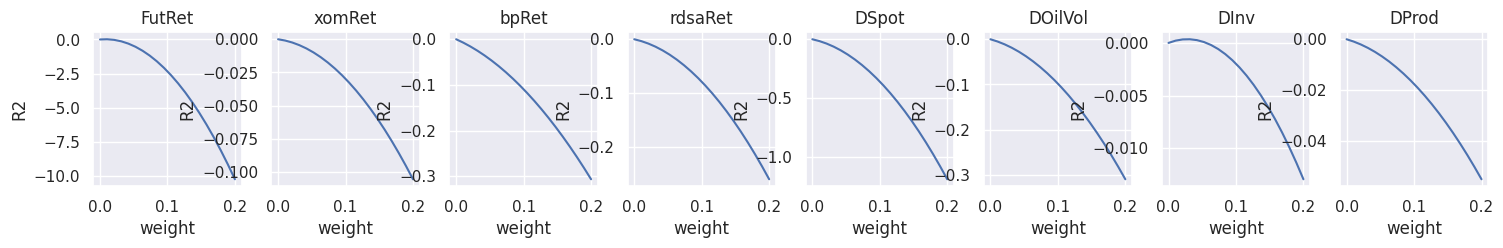

In [12]:
res_directory = glob('res_Forward_Lasso/*rolling:True*normalize:False*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

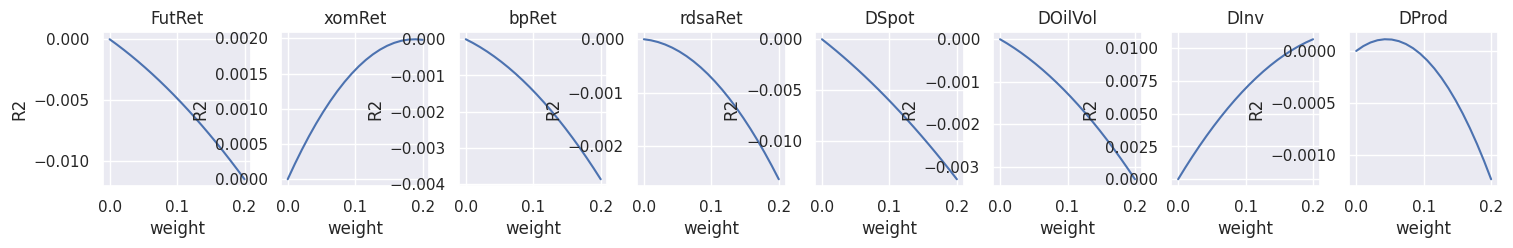

In [13]:
res_directory = glob('res_Forward_Lasso/*rolling:True*select_significant:True*normalize:True*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

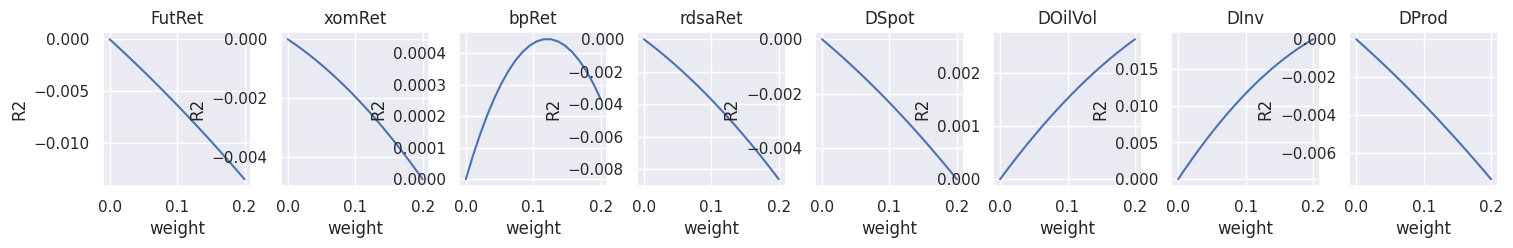

In [14]:
res_directory = glob('res_Forward_Lasso/*rolling:True*select_significant:False*normalize:True*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

In [16]:
res.keys()

dict_keys(['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol', 'DInv', 'DProd'])

In [17]:
res['FutRet'].keys()

dict_keys(['MSE', 'true', 'pred', 'pred_wls', 'trend', 'df_all_features'])

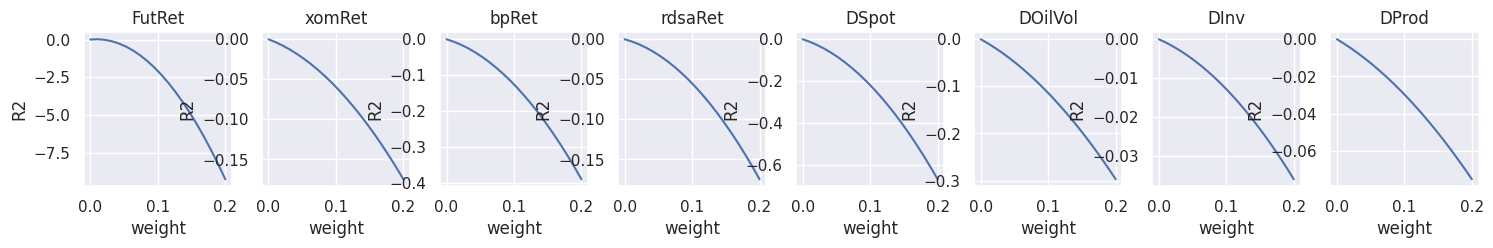

In [4]:
res_directory = glob('res_Forward_Lasso/*rolling:False*normalize:False*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

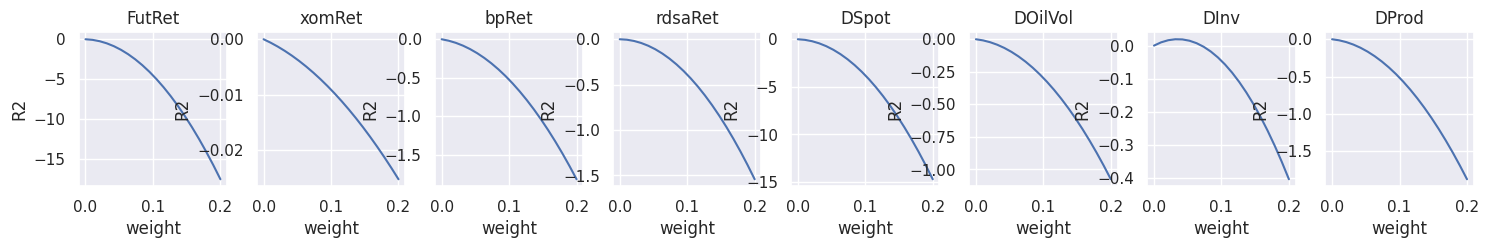

In [9]:
res_directory = glob('res_Forward_Lasso/*rolling:False*normalize:True*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

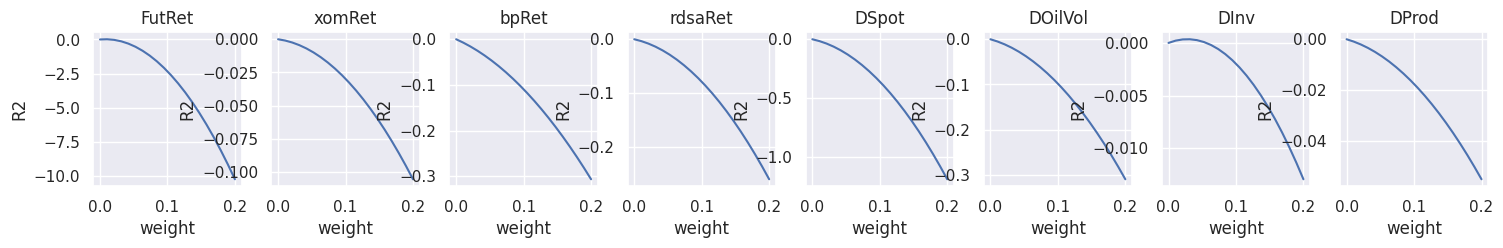

In [5]:
res_directory = glob('res_Forward_Lasso/*rolling:True*normalize:False*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

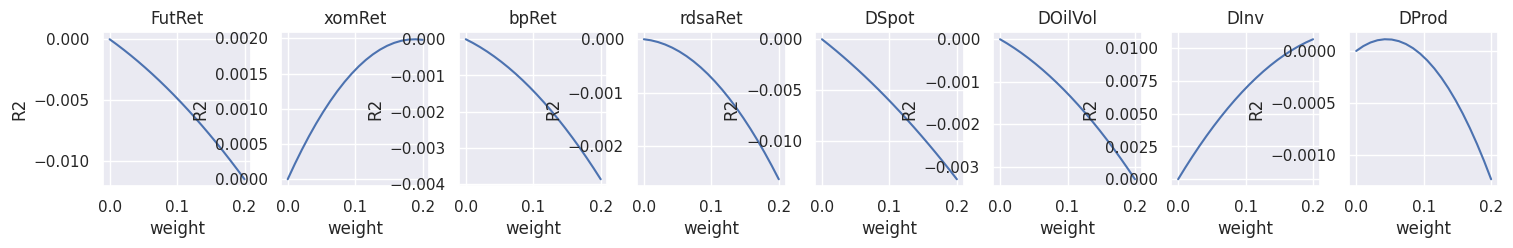

In [8]:
res_directory = glob('res_Forward_Lasso/*rolling:True*normalize:True*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

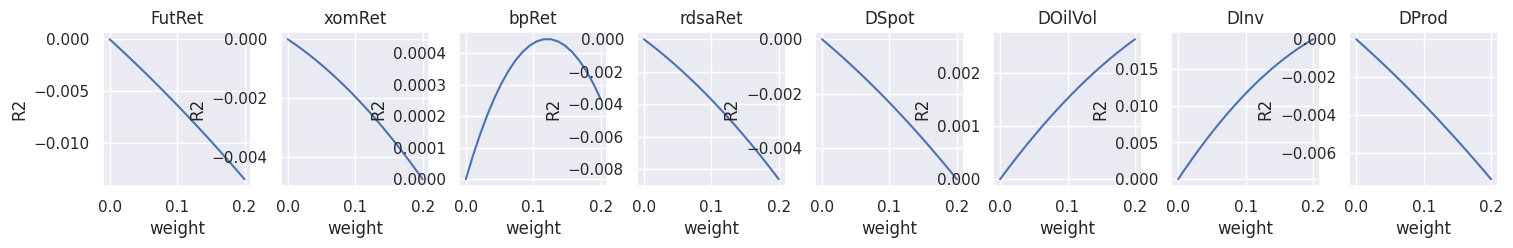

In [11]:
res_directory = glob('res_Forward_Lasso/*rolling:True*select_significant:False*normalize:True*/test/res.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
plot_blends(res, wt_max=0.2)

In [1]:
from OOSfuncs import data_set, get_test_row_range, ind_var_list
from replicate import parse_option
import sys
sys.argv = ['']
opt = parse_option()

ind_vars = ['entropy', 'artcount', 'sCo', 'fCo',
           'sGom', 'fGom', 'sEnv', 'fEnv', 'sEpg', 'fEpg', 'sBbl', 'fBbl', 'sRpc',
           'fRpc', 'sEp', 'fEp', 'PCAsent', 'PCAall', 'PCAfreq']


d_var = 'FutRet'
data = data_set(d_var=d_var, replicate=True)#[['date']+ind_vars]

In [3]:
from replicate import get_train_test_split
x_train, data_xtest, y_train, data_ytest, scaler = get_train_test_split(d_var, forecast_start, opt)

In [4]:
x_train

,entropy,artcount,sCo,fCo,sGom,fGom,sEnv,fEnv,sEpg,fEpg,sBbl,fBbl,sRpc,fRpc,sEp,fEp,PCAsent,PCAall,PCAfreq
8,2.316919,-1.151378,1.295613,-1.448586,-1.665324,1.139834,0.785789,-0.793002,0.127232,-1.186065,-0.143620,0.770895,-1.256353,2.548024,0.135758,-0.401937,-2.096313,3.497296,2.721570
9,2.309221,-1.053017,0.552580,-1.309104,-1.433085,1.108109,0.901109,-0.726000,0.368267,-1.354697,-0.077223,1.284705,-2.142196,2.342406,0.179778,-0.360666,-2.256208,3.769080,2.893785
10,2.303402,-0.900011,0.524520,-1.265139,-1.361011,1.056013,0.760788,-0.607584,0.567205,-1.416116,-0.121673,1.719231,-2.957757,2.399355,0.311707,-0.461428,-2.065481,3.682003,2.867021
11,2.300856,-0.871159,0.477519,-1.260574,-1.186593,0.975742,0.688290,-0.722767,0.368573,-1.268197,-0.394217,2.144023,-3.382976,3.000295,0.205872,-0.413432,-2.090147,3.809543,2.996290
12,2.301733,-1.000121,0.556713,-1.277638,-1.064192,1.024384,1.168156,-1.002391,0.561036,-1.280794,-0.510440,2.121712,-4.069268,4.015700,0.339456,-0.474774,-1.888895,3.833629,3.215716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2.270977,-1.360778,1.078536,-0.398176,-1.729702,0.923850,0.634844,-0.862666,-1.684798,-0.357720,0.192726,-0.877680,-1.436992,1.295879,1.090487,-1.285815,-2.058244,2.972183,1.814382
249,2.275194,-1.304385,1.105512,-0.459760,-1.833489,0.967567,0.726343,-0.863150,-1.552454,-0.330884,0.295578,-0.954347,-1.914970,1.697113,1.117579,-1.255463,-1.857099,2.578866,1.493260
250,2.286426,-1.213455,0.827127,-0.523336,-2.195457,0.970777,0.834808,-0.968222,-1.726012,-0.320716,0.335951,-1.021131,-1.948387,2.159618,0.817510,-1.135572,-1.597115,2.187210,1.223047
251,2.286960,-1.342418,0.756213,-0.678199,-3.025154,1.206030,1.115337,-1.122511,-1.536087,-0.571705,0.438715,-1.052513,-1.133478,2.078490,0.863253,-1.274872,-1.386097,1.957664,1.130200


In [5]:
y_train

8       93.249840
9       84.431847
10      79.225945
11      89.519661
12      78.784210
          ...    
248    125.988396
249    122.662399
250    117.279030
251    121.331337
252    110.222160
Name: FutRet_t8, Length: 245, dtype: float32

In [6]:
# artcount, etc. are normalized using full sample in v19; PCA are not
data['artcount'].std()
data['PCAsent'].std()

1.4890561176752983

In [7]:
print('Training start: X')
display(data[data['entropy']==x_train['entropy'].iloc[0]][['FutRet','date','entropy']])
print('Training start: Y')
display(data[data['FutRet_t8']==y_train.iloc[0]][['FutRet','date','entropy']])

print('Training end: X')
display(data[data['entropy']==x_train['entropy'].iloc[-1]][['FutRet','date','entropy']])
print('Training end: Y')
display(data[data['FutRet_t8']==y_train.iloc[-1]][['FutRet','date','entropy']])

Training start: X


,FutRet,date,entropy
0,NaN,1998-05-01,2.316919


Training start: Y


,FutRet,date,entropy
256,85.023308,2003-03-28,2.305501


Training end: X


,FutRet,date,entropy
244,120.078568,2003-01-03,2.289408


Training end: Y


,FutRet,date,entropy
500,92.713081,2007-11-30,2.172143


training X: 19980510 - 20030310 
(PCA uses 0510 to 0430 on the same training model) 
(topic model: 199805 - 200304; inner join training and topic model)
training Y_fwd (FutRet_fwd): 19980510 (computed from 19980510 to 19980710) - 20030310
test X: 20030510 (topic model: 199805 - 200304; f1 f2 s1 s2 are all on 20030430)
coefficients come from training
test Y (FutRet_fwd): 20030510 (computed from 20030510 to 20030710)

normalize X using 19980510 - 20030510
normalize Y_fwd using 19980510 - 20030310 (mean and std in scaler comes from this window)

for demo:
write a function to be looped to train and test: 
input: start_date and end_date (19980510, 20030510, d_var, cvs=3, frequency=8)
output: three numbers (forecast, truth, scaler) + (best_lambda, ...)
return {start_date, end_date, ...} specific to the inputs (19980510, 20030510, d_var) and storing the inputs

parallelizable

In [1]:
from get_best_lambda import get_train_test_split, parse_option
import sys
sys.argv = ['']
opt = parse_option()
d_var = 'FutRet'
opt.rolling = False

import pandas as pd
forecast_start = pd.to_datetime('2007-11-30')

x_train, x_test, y_train, y_test, YYYYMM_end, scaler = get_train_test_split(d_var, forecast_start, opt)

100%|█████████████████████████████████████| 876/876 [00:00<00:00, 542238.83it/s]
/user/kh3191/.conda/envs/tmle/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/user/kh3191/.conda/envs/tmle/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

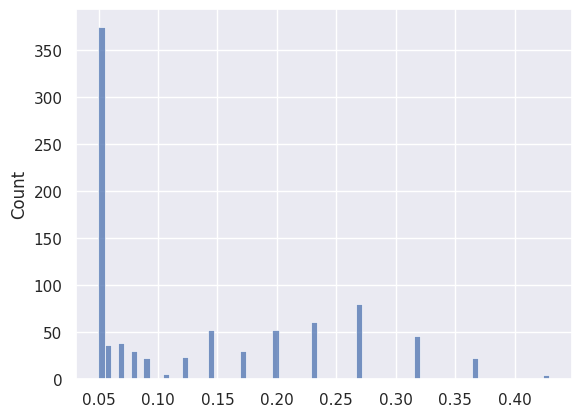

In [45]:
best_lambda_list = []
for forecast_start, (YYYYMM_end, best_lambda, scaler) in tqdm(best_lambda_dic.items()):
    best_lambda_list.append(best_lambda)
    
sns.histplot(best_lambda_list, bins=70)

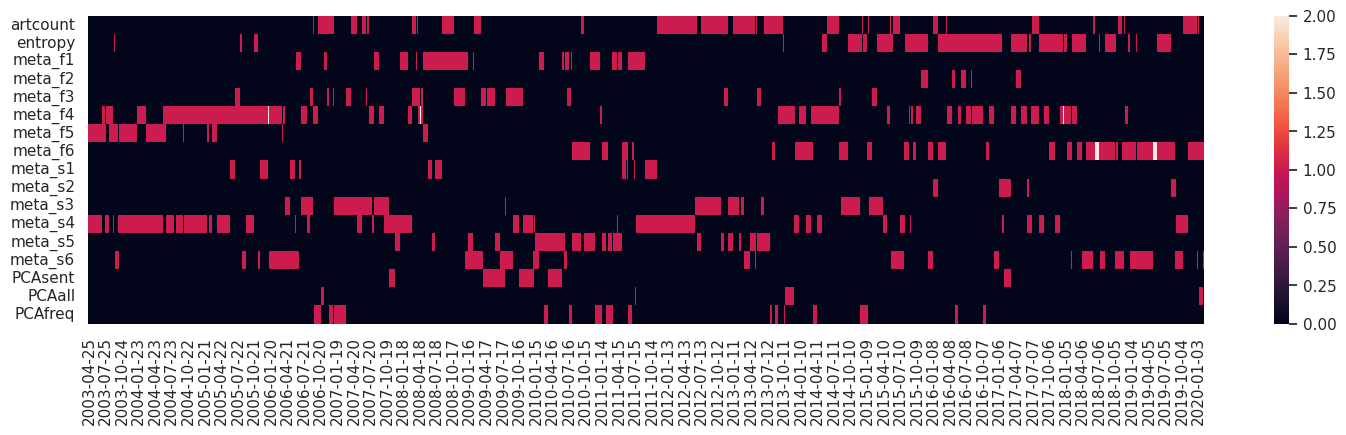

In [48]:
fig, ax= plt.subplots(figsize=(18,4))
ax=sns.heatmap(df_all_features)

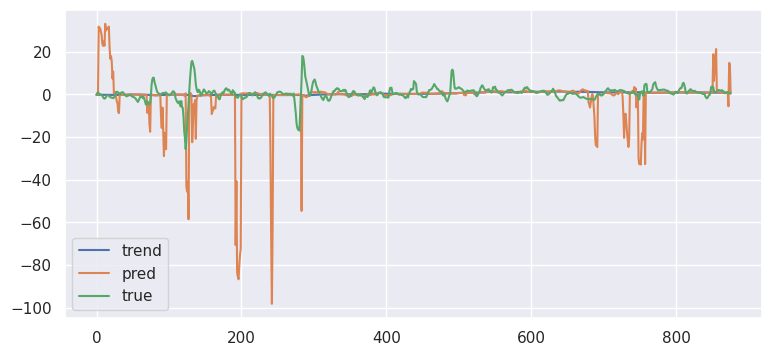

In [27]:
import pandas as pd
true_arr_ma = pd.Series(true_arr).rolling(260).mean()

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(trend_arr, label='trend')
ax.plot(pred_arr, label='pred')

ax.plot(true_arr,  label='true')
#ax.plot(true_arr_ma,  label='true_ma')

ax.legend()

In [37]:
# WLS
for d_var in d_var_list:
    pred_wls_arr = np.array(list(pred_wls[d_var].values()))
    
    num = (true_arr - pred_wls_arr).var()
    den = (true_arr - trend_arr).var()
    print(d_var, num/den)

DSpot 1.1413542811173236


In [ ]:
sum((true_arr - pred_arr)^2) / sum((true_arr-in_sample_mean)^2)

- replace OLS by lasso with smaller tuning grid (ignore OLS)
- try WLS (weights double) w/o cross validation
- sum((true_arr - pred_arr)^2) / sum((true_arr-in_sample_mean)^2)
- pred_arr *= w, pred_arr += (1-w)*in_sample_mean (not necessarily across 5 years)

$$
\hat\beta = \arg\min \sum_{t=1}^258 W_{t+1}(Y_{t+1}-X_{t}'\beta)^2
$$

$$
W_{1} = 1, \quad W_{258}=2, \quad W_t = \frac{1}{258} t + \frac{257}{258} 
$$

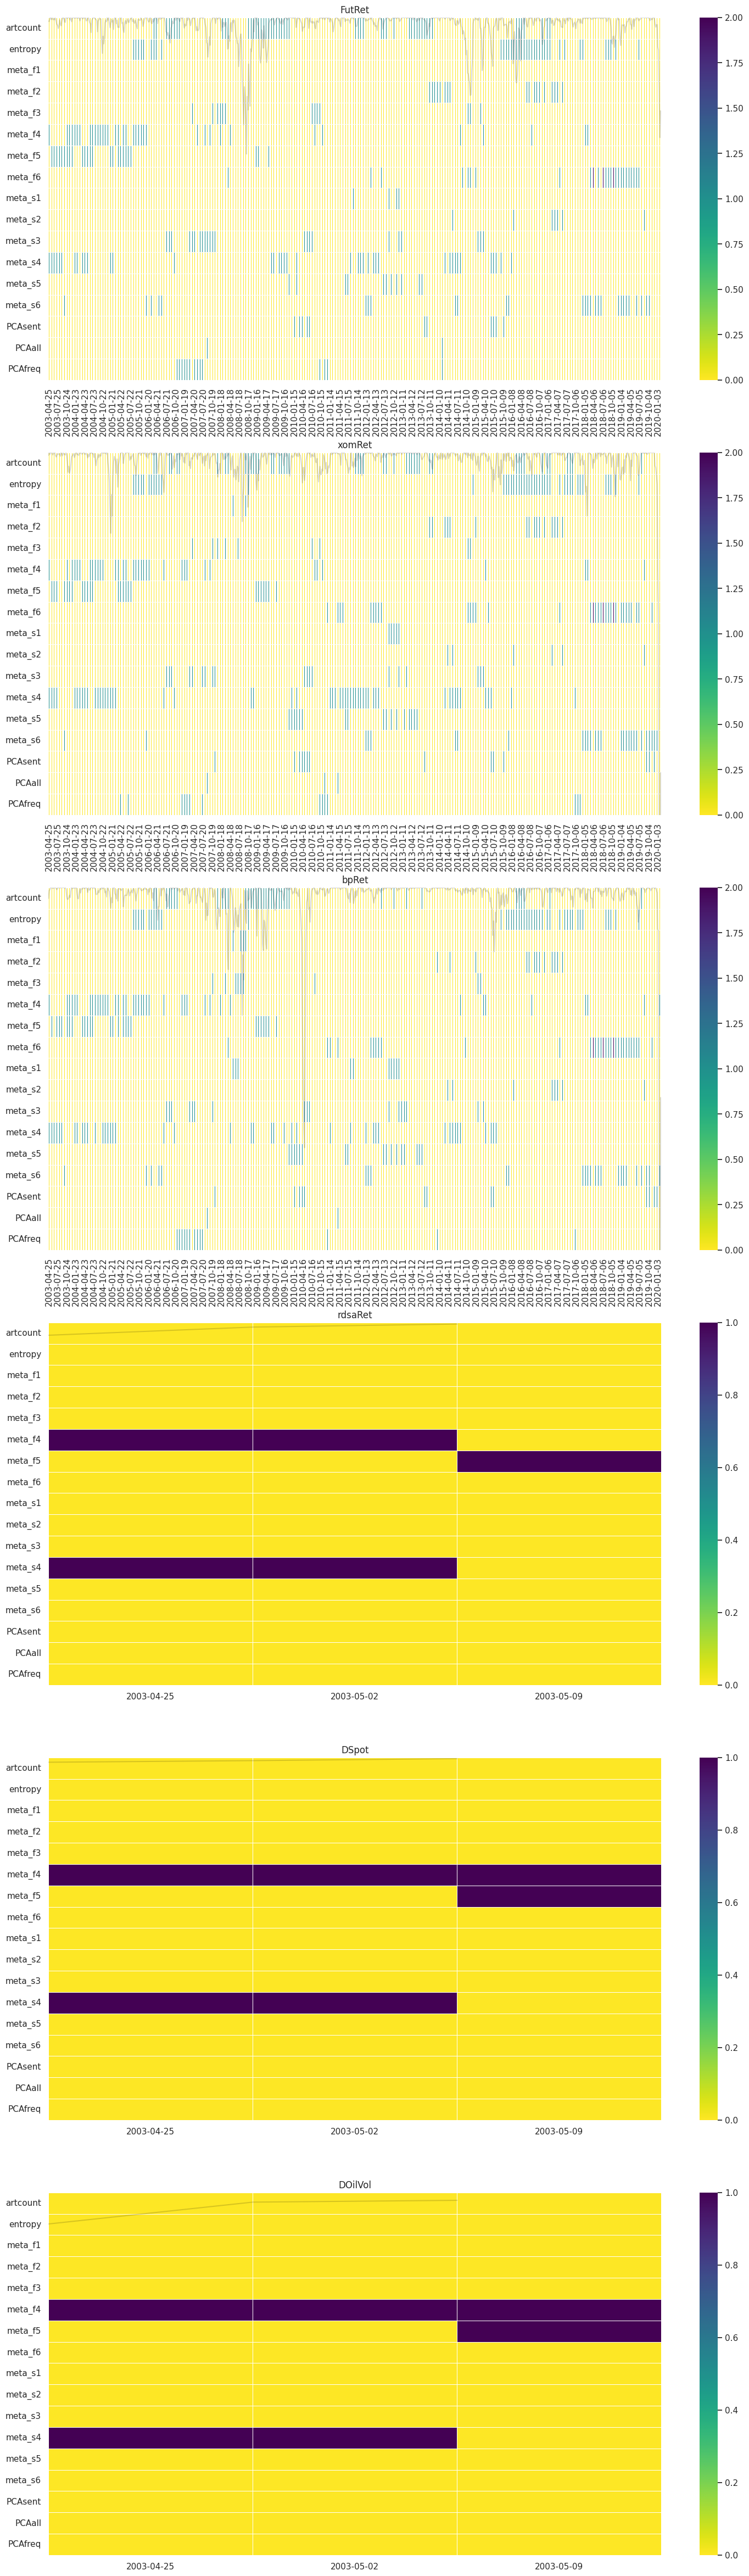

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

d_var_list = ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol']
fig, ax = plt.subplots(figsize=(18,10*len(d_var_list)), nrows=len(d_var_list))
for i, d_var in enumerate(d_var_list):
    sns.heatmap(df_dic[d_var], cmap="viridis_r", linewidths=.5, ax=ax[i])
    ax[i].plot(pd.Series(MSE[d_var])/4, color='black', alpha=0.15)
    ax[i].set_title(d_var);
fig.savefig('forward_lasso.pdf')

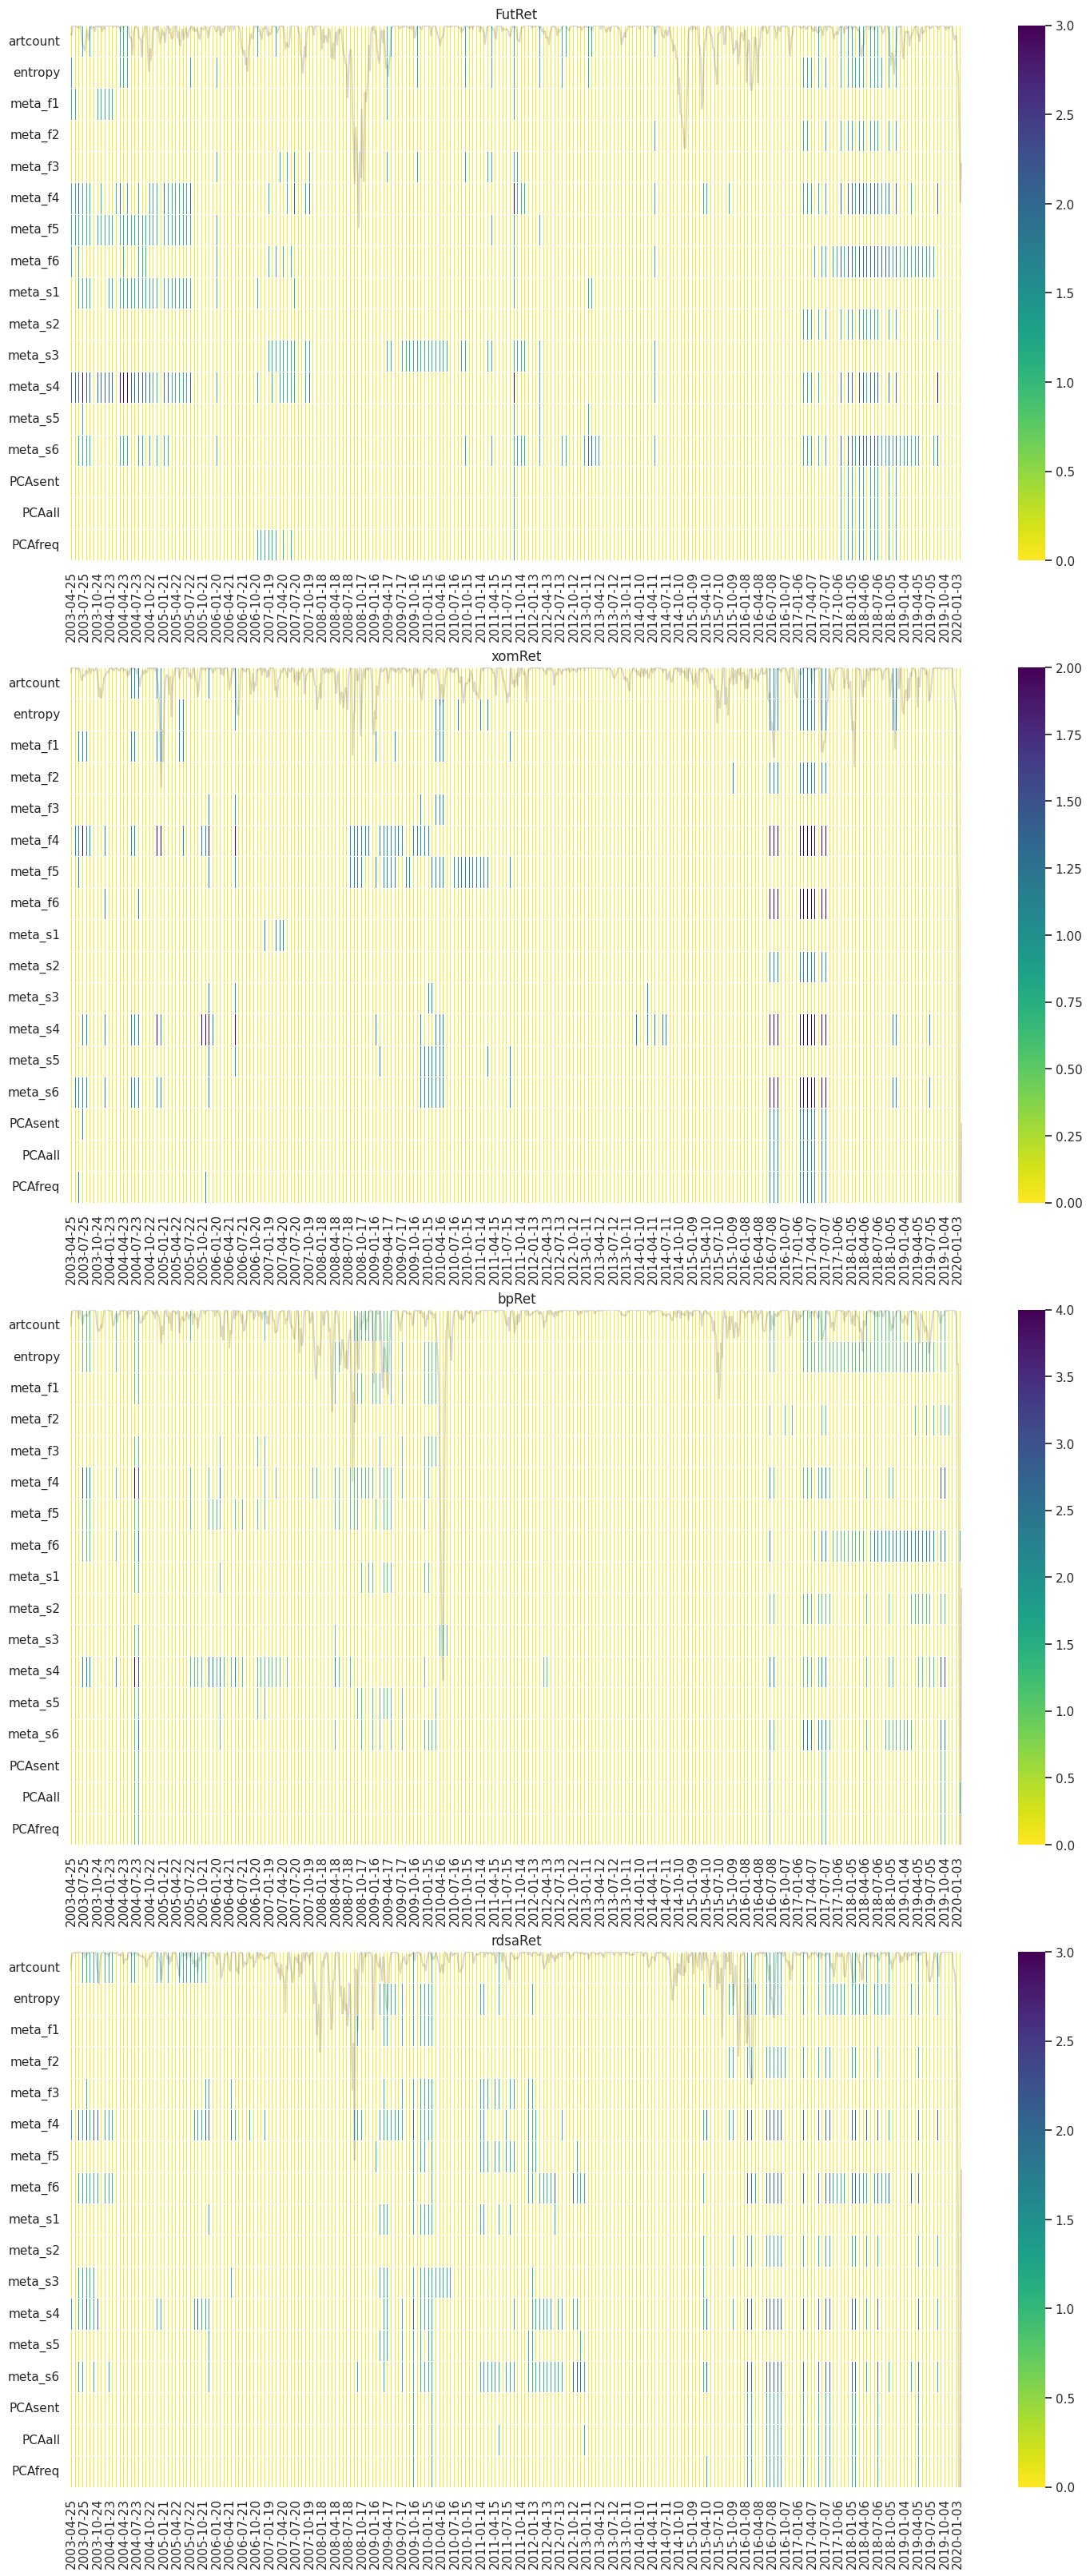

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

d_var_list = ['FutRet', 'xomRet', 'bpRet', 'rdsaRet']
fig, ax = plt.subplots(figsize=(18,10*len(d_var_list)), nrows=len(d_var_list))
for i, d_var in enumerate(d_var_list):
    sns.heatmap(df_dic[d_var], cmap="viridis_r", linewidths=.5, ax=ax[i])
    ax[i].plot(pd.Series(MSE[d_var])/4, color='black', alpha=0.15)
    ax[i].set_title(d_var);
    
#fig.savefig('lasso.pdf')

- 3 folds: minimize overlap among the folds to have more indenpendent observations
- reverse-transform prediced values
- store true, pred, in-sample mean and std (in actual scale of Y)

- compare OOS R^2
- select 1/2/3 best variables according to recursive OLS

- plot OOS R2 against w

# replicate Figure 5

https://github.com/hmamaysky/Energy/blob/master/Analysis/oos_energy.py

generates Figure 6

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
s = pd.read_csv('test.csv', index_col=0).apply(pd.eval)['0'][:100]

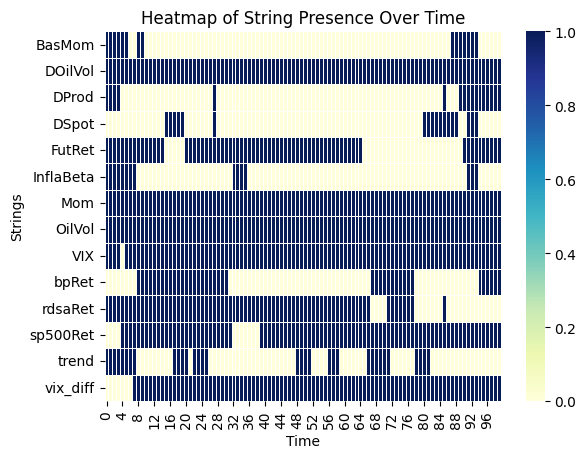

In [19]:
all_strings = sorted(set.union(*s.apply(set)))

heatmap_df = pd.DataFrame(0, index=s.index, columns=all_strings)

for time, strings in s.items():
    heatmap_df.loc[time, strings] = 1

sns.heatmap(heatmap_df.T, cmap="YlGnBu", linewidths=.5)
plt.xlabel('Time')
plt.ylabel('Strings')
plt.title('Heatmap of String Presence Over Time');

In [1]:
import pickle
with open('lasso_models/twoandtwo/weekly/Lasso_10fold_8wk_t_rmse.p', 'rb') as file:
    var_coef_dict = pickle.load(file)

In [4]:
df = pd.read_excel('lasso_models/twoandtwo/weekly/Lasso_10fold_8wk_t.xlsx')
df

,Unnamed: 0,FutRet,DOilVol
0,Base Model,1.082025,0.987142
1,Text Model,1.022090,1.042801
2,Full Model,1.075552,0.998451
3,Text Model (on Base),0.944609,1.056384
4,Full Model (on Base),0.994018,1.011457


In [2]:
var_coef_dict['DOilVol']['const_rmse']

[nan,
 43.45211407057289,
 33.06254716718029,
 28.691644615269606,
 26.010791643154267,
 23.87141595636798,
 21.883643862834397,
 20.27620717908008,
 18.967279360853848,
 17.92453172779683,
 17.068085952344443,
 16.275895004157274,
 15.607953439716457,
 15.086276885305912,
 14.64296569659259,
 14.15029838951376,
 13.72816685722821,
 13.354871893671715,
 13.028838536030264,
 12.77560904259108,
 12.452140322332772,
 12.152050978894884,
 11.874041677991215,
 11.65315370002199,
 11.420911319183197,
 11.425401748472371,
 11.376370495708086,
 11.389193559398917,
 11.3502310101515,
 11.222396862150328,
 11.03818100159534,
 10.861481342701838,
 10.698895197977762,
 10.536005891262738,
 10.384790047748181,
 10.238982298498868,
 10.096952184887606,
 9.96092838571707,
 9.831477544657236,
 9.761770370034661,
 9.652512884674948,
 9.583869284400922,
 9.505115852563604,
 9.42454359580033,
 9.329182852428874,
 9.2249562953821,
 9.130079671299509,
 9.036222937585421,
 8.942049196281111,
 8.853900612762

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



import pandas as pd
from OOSfuncs import data_set

In [2]:
pd.read_excel('forward_models/Lasso_10fold_8wk1vars_forward.xlsx', index_col=0)

,FutRet,xomRet,bpRet,rdsaRet,DSpot,DOilVol,DInv,DProd
Constant,13.937549,7.913096,10.530635,9.585772,15.143156,14.594566,1.848200,3.331014
Forward Model,14.359436,7.974742,10.595043,9.696877,15.452190,14.851983,1.838584,3.377682


In [3]:
pd.read_excel('forward_models/Lasso_10fold_8wk7vars_forward.xlsx', index_col=0)

,FutRet,xomRet,bpRet,rdsaRet,DSpot,DOilVol,DInv,DProd
Constant,13.937549,7.913096,10.530635,9.585772,15.143156,14.594566,1.848200,3.331014
Forward Model,15.650146,8.182431,11.232390,9.983437,16.901542,13.630102,1.842971,3.467305


In [4]:
pd.read_excel('forward_models/Lasso_10fold_8wk6vars_forward.xlsx', index_col=0)

,FutRet,xomRet,bpRet,rdsaRet,DSpot,DOilVol,DInv,DProd
Constant,13.937549,7.913096,10.530635,9.585772,15.143156,14.594566,1.848200,3.331014
Forward Model,15.667233,8.181715,11.170165,9.865876,16.943970,13.155123,1.850439,3.483700


In [5]:
pd.read_excel('forward_models/Lasso_10fold_8wk5vars_forward.xlsx', index_col=0)

,FutRet,xomRet,bpRet,rdsaRet,DSpot,DOilVol,DInv,DProd
Constant,13.937549,7.913096,10.530635,9.585772,15.143156,14.594566,1.848200,3.331014
Forward Model,15.555451,8.188387,10.964623,9.830163,17.201554,13.206634,1.869873,3.421845


In [6]:
def get_test_week_list(d_var, updating_window=5, frequency=1):
    time_col = data_set(d_var)['date'] 
    test_week_list = [time for time in time_col if time>=time_col[0]+pd.Timedelta(str(7*updating_window*52)+'days')][::frequency]
    return test_week_list
    
def plot_RMSE(d_var, no_variables, ax=None):
    df = pd.read_excel(f'forward_models/Lasso_10fold_8wk{no_variables}vars_forward_rmses.xlsx', index_col=0)
    df.index = get_test_week_list(d_var)
    if not ax:
        fig, ax = plt.subplots(figsize=(18,6))
    df.loc[:,df.columns.str.startswith(d_var)].plot(ax=ax)
    ax.set_yscale('log')
    if no_variables == 1:
        ax.set_title(f'Cumulative RMSE of predicting {d_var} with top {no_variables} variable')
    else:
        ax.set_title(f'Cumulative RMSE of predicting {d_var} with top {no_variables} variables')

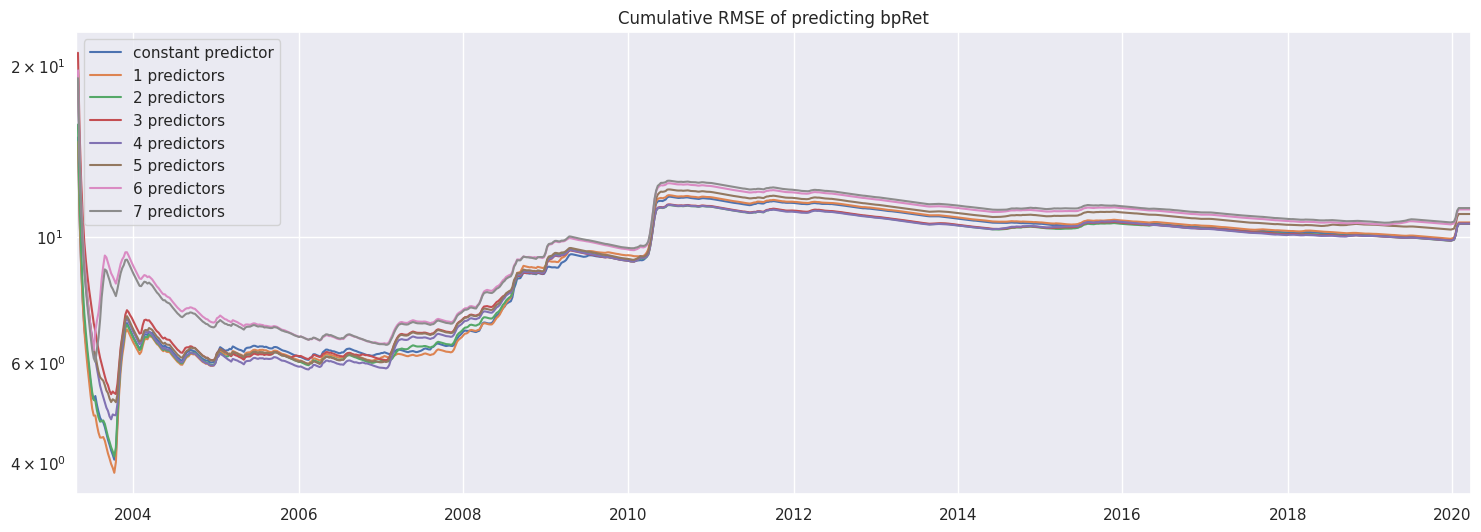

In [9]:
d_var = 'bpRet'

no_variables_list = range(1,8)
fig, ax = plt.subplots(figsize=(18,6))
plot_RMSE(f'{d_var}_constant', 1, ax=ax)
for no_variables in no_variables_list:
    plot_RMSE(f'{d_var}_forward', no_variables, ax=ax)
ax.set_title(f'Cumulative RMSE of predicting {d_var}')
ax.legend(['constant predictor']+[f'{no_variables} predictors' for no_variables in no_variables_list]);